Using the latest cached version of the dataset since wics/strategy-qa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'strategyQA' at /Users/gusfridell/.cache/huggingface/datasets/wics___strategy-qa/strategyQA/0.0.1/f4d03d5ee3d1e302a9b4200e71231c46013eaeb2 (last modified on Wed Sep  3 20:57:41 2025).
Evaluating: 100%|██████████| 22/22 [01:23<00:00,  3.78s/it]


Train Loss: 0.8028, Train Acc: 0.4679, Val Acc: 0.4869


Evaluating: 100%|██████████| 22/22 [01:25<00:00,  3.90s/it]


Train Loss: 0.6949, Train Acc: 0.5072, Val Acc: 0.5539


Evaluating: 100%|██████████| 22/22 [01:22<00:00,  3.77s/it]


Train Loss: 0.6909, Train Acc: 0.5234, Val Acc: 0.5452


Evaluating: 100%|██████████| 22/22 [01:22<00:00,  3.75s/it]


Train Loss: 0.6898, Train Acc: 0.5296, Val Acc: 0.5539


Evaluating: 100%|██████████| 22/22 [01:22<00:00,  3.74s/it]


Train Loss: 0.6883, Train Acc: 0.5459, Val Acc: 0.5481


Evaluating: 100%|██████████| 22/22 [01:21<00:00,  3.70s/it]


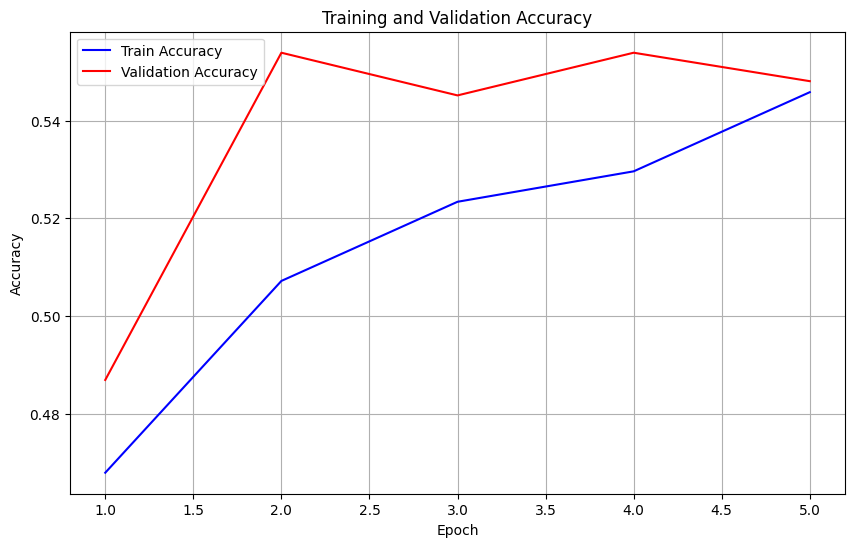

results
0.5539358600583091
0.5377906976744186


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = load_dataset("wics/strategy-qa")


def prepare_data(split_data):
    questions = []
    labels = []
    
    for item in split_data:
        # Concatenate question and facts
        question = item['question']
        facts = item.get('facts', [])
        if facts:
            input_text = question + " " + " ".join(facts)
        else:
            input_text = question
        
        questions.append(input_text)
        labels.append(1 if item['answer'] else 0)  # Convert bool to int
    
    return questions, labels


all_questions, all_labels = prepare_data(dataset['test'])

train_frac = 0.7
val_frac = 0.15
test_frac = 0.15

train_q, temp_q, train_l, temp_l = train_test_split(
    all_questions, all_labels, 
    test_size=(val_frac + test_frac), 
    random_state=42, 
    stratify=all_labels
)
val_q, test_q, val_l, test_l = train_test_split(
    temp_q, temp_l, 
    test_size=(test_frac / (val_frac + test_frac)), 
    random_state=42, 
    stratify=temp_l
)

class StrategyQADataset(Dataset):
    def __init__(self, questions, labels, tokenizer, max_length=512):
        self.questions = questions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self, idx):
        question = self.questions[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            question,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
train_dataset = StrategyQADataset(train_q, train_l, tokenizer)
val_dataset = StrategyQADataset(val_q, val_l, tokenizer)
test_dataset = StrategyQADataset(test_q, test_l, tokenizer)


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class ModernBERTClassifier(nn.Module):
    def __init__(self, model_name, num_classes=2):
        super(ModernBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = self.classifier(pooled_output)
        return logits

model = ModernBERTClassifier("answerdotai/ModernBERT-base")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=2e-5)
num_epochs = 5

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

train_accuracies = []
val_accuracies = []
best_val_accuracy = 0
best_model_state = None

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = evaluate(model, val_loader, device)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict().copy()

model.load_state_dict(best_model_state)

# Evaluate on test set
test_accuracy = evaluate(model, test_loader, device)

plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("results")

print(best_val_accuracy)
print(test_accuracy)


Using the latest cached version of the dataset since wics/strategy-qa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'strategyQA' at /Users/gusfridell/.cache/huggingface/datasets/wics___strategy-qa/strategyQA/0.0.1/f4d03d5ee3d1e302a9b4200e71231c46013eaeb2 (last modified on Wed Sep  3 20:57:41 2025).



Epoch 1/2


Evaluating: 100%|██████████| 22/22 [01:24<00:00,  3.84s/it]


Train Loss: 0.7918, Train Acc: 0.5321, Val Acc: 0.5335

Epoch 2/2


Evaluating: 100%|██████████| 22/22 [01:25<00:00,  3.86s/it]


Train Loss: 0.7985, Train Acc: 0.5321, Val Acc: 0.5335


Evaluating: 100%|██████████| 22/22 [01:21<00:00,  3.70s/it]


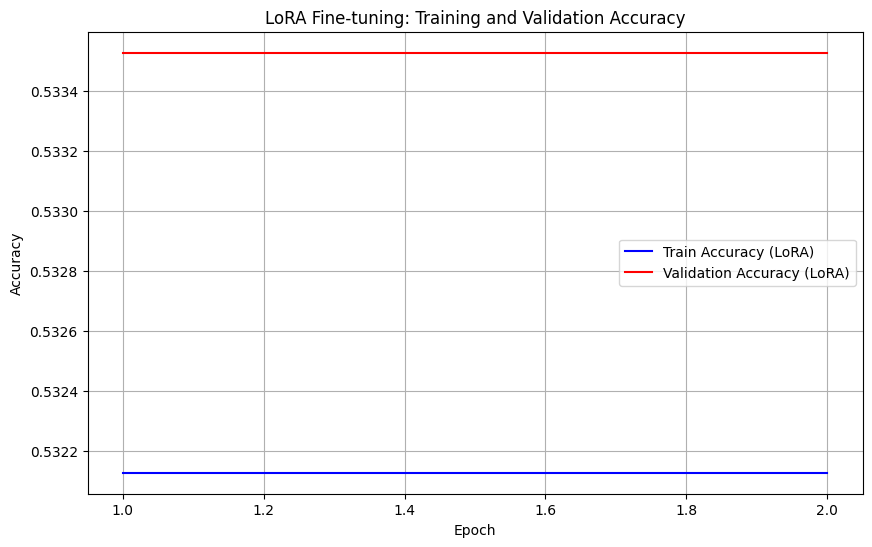


LORA RESULTS
Trainable parameters: 1538
Best validation accuracy: 0.5335
Test accuracy: 0.5320


In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Custom LoRA Layer for exact parameter matching
class LoRALayer(nn.Module):
    def __init__(self, original_layer, rank=1):
        super(LoRALayer, self).__init__()
        self.original_layer = original_layer
        self.rank = rank
        
        # Freeze original layer
        for param in self.original_layer.parameters():
            param.requires_grad = False
            
        # For exact parameter matching with classification head (1538 params):
        # apply LoRA to Wo
        # Query portion: 768 x 768, so rank=1 gives 1×(768+768) = 1536 params
        # add 2 additional params to match exactly = 1538 total
        
        if rank == 1 and original_layer.out_features == 2304:  # wkqv has 2304 
            # LoRA only on query portion (first 768 dimensions of output)
            self.lora_A = nn.Parameter(torch.randn(rank, 768) * 0.01)
            self.lora_B = nn.Parameter(torch.zeros(768, rank))
            # Add 2 extra parameters to match exactly 1538
            self.extra_params = nn.Parameter(torch.zeros(2))
        else:
            # Standard LoRA for Wo
            in_features = original_layer.in_features
            out_features = original_layer.out_features
            self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.01)
            self.lora_B = nn.Parameter(torch.zeros(out_features, rank))
        
    def forward(self, x):
        original_output = self.original_layer(x)
        
        if hasattr(self, 'extra_params'):  # Wo case
             # Apply LoRA only to query portion (first 768 outputs)
             lora_output = torch.matmul(x, self.lora_A.T)
             lora_output = torch.matmul(lora_output, self.lora_B.T)
            
             # Add LoRA output only to the query portion
             result = original_output.clone()
             result[:, :, :768] += lora_output
             return result
        else:
            # Standard LoRA
            lora_output = torch.matmul(x, self.lora_A.T)
            lora_output = torch.matmul(lora_output, self.lora_B.T)
            return original_output + lora_output


class ModernBERTLoRAClassifier(nn.Module):
    def __init__(self, model_name, rank=1, num_classes=2):
        super(ModernBERTLoRAClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Freeze all BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Apply LoRA to Wo in last transformer layer
        last_layer_attn = self.bert.layers[-1].attn
        original_wo = last_layer_attn.Wo
        last_layer_attn.Wo = LoRALayer(original_wo, rank=rank)

        # freeze classification head
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        for param in self.classifier.parameters():
            param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled_output)
        return logits

# prepare data (copied from above)
dataset = load_dataset("wics/strategy-qa")

def prepare_data(split_data):
    questions = []
    labels = []
    
    for item in split_data:
        question = item['question']
        facts = item.get('facts', [])
        if facts:
            input_text = question + " " + " ".join(facts)
        else:
            input_text = question
        
        questions.append(input_text)
        labels.append(1 if item['answer'] else 0)
    
    return questions, labels

all_questions, all_labels = prepare_data(dataset['test'])

train_frac = 0.7
val_frac = 0.15
test_frac = 0.15

train_q, temp_q, train_l, temp_l = train_test_split(
    all_questions, all_labels, 
    test_size=(val_frac + test_frac), 
    random_state=42, 
    stratify=all_labels
)
val_q, test_q, val_l, test_l = train_test_split(
    temp_q, temp_l, 
    test_size=(test_frac / (val_frac + test_frac)), 
    random_state=42, 
    stratify=temp_l
)

class StrategyQADataset(Dataset):
    def __init__(self, questions, labels, tokenizer, max_length=512):
        self.questions = questions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self, idx):
        question = self.questions[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            question,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
train_dataset = StrategyQADataset(train_q, train_l, tokenizer)
val_dataset = StrategyQADataset(val_q, val_l, tokenizer)
test_dataset = StrategyQADataset(test_q, test_l, tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize LoRA model
model = ModernBERTLoRAClassifier("answerdotai/ModernBERT-base", rank=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
lora_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(lora_params, lr=2e-5)
num_epochs = 2

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc="LoRA Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

train_accuracies = []
val_accuracies = []
best_val_accuracy = 0
best_lora_weights = {}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = evaluate(model, val_loader, device)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_lora_weights = {
            name: param.clone() 
            for name, param in model.named_parameters() 
            if param.requires_grad
        }

# Load best weights
for name, param in model.named_parameters():
    if name in best_lora_weights:
        param.data.copy_(best_lora_weights[name])

# Evaluate on test set
test_accuracy = evaluate(model, test_loader, device)

# Plot results
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy (LoRA)')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy (LoRA)')
plt.title('LoRA Fine-tuning: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("\nLORA RESULTS")
print(f"Trainable parameters: {trainable_params}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

In [32]:
mod = AutoModel.from_pretrained("answerdotai/ModernBERT-base")
model = mod.to(device)
model.layers[-1]

ModernBertEncoderLayer(
  (attn_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): ModernBertAttention(
    (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
    (rotary_emb): ModernBertRotaryEmbedding()
    (Wo): Linear(in_features=768, out_features=768, bias=False)
    (out_drop): Identity()
  )
  (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): ModernBertMLP(
    (Wi): Linear(in_features=768, out_features=2304, bias=False)
    (act): GELUActivation()
    (drop): Dropout(p=0.0, inplace=False)
    (Wo): Linear(in_features=1152, out_features=768, bias=False)
  )
)